# Getting Started

## Install Dependencies

This is a tutorial of using D4 in Python. Before you started trying this document, please make sure you have D4 package and `d4tools` binary installed. 

* To install the d4tools binary, please read the instruction from [this link](https://github.com/38/d4-format#installation--2-minutes)
* To install `pyd4`, please run command `pip install pyd4`

## Download dataset

To download the dataset we are using for this interactive document, please use the following links:
* WGS Sample HG002: https://home.chpc.utah.edu/~u0875014/hg002.cram
* Reference Genome: https://home.chpc.utah.edu/~u0875014/hg19.fa.gz

Please make sure that index files is accessible for both CRAM file and reference genome.


# Download Data

In [6]:
import os
os.system("mkdir -p data")
os.system("cd data && wget --continue https://home.chpc.utah.edu/~u0875014/hg002.cram")
os.system("cd data && wget --continue https://home.chpc.utah.edu/~u0875014/hg002.cram.crai")
os.system("cd data && wget --continue https://home.chpc.utah.edu/~u0875014/hg19.fa.gz")
os.system("cd data && samtools view -T data/hg19.fa.gz data/hg002.cram | head -n 1")

0

# Create depth profile for an alignment file

pyd4 provides a very fast way to get the per-base depth profile of an alignment file, which usually takes less than 2 minutes on a laptop. As the begining of this tutorial, we profile the per-base depth from the CRAM file we previously downloaded. 

In [13]:
import pyd4
# Create a D4 file from depth, generate data/hg002.d4
file_handle = pyd4.bam_to_d4("data/hg002.cram", reference_genome = "data/hg19.fa.gz.fai", output = "data/hg002.d4")

# Open a D4 file on disk and load data

In [1]:
from pyd4 import D4File

# To open file, you can simply initialize a D4File instance
file = D4File("data/hg002.d4")

# To load data as numpy array from the file
chr1_data = file["1"]
print(chr1_data.mean())

24.75883394890318


# Visualization data in d4 file
You can also use `D4File.resample` to get windowed data of a chromosome and return it as numpy array. Then you can use the numpy array to visualize the depth data.

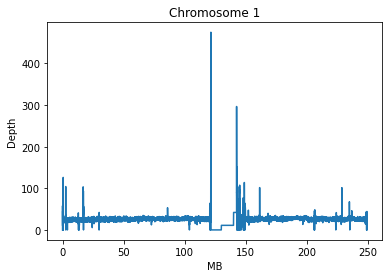

In [12]:
from pyd4 import D4File
from matplotlib import pyplot as plt 

# To open file, you can simply initialize a D4File instance
file = D4File("data/hg002.d4")

chr1_data = file.resample("1", bin_size = 10000)[0]
x = [i * 10000 / 1000000 for i, _ in enumerate(chr1_data)]
plt.title("Chromosome 1") 
plt.xlabel("MB") 
plt.ylabel("Depth") 
plt.plot(x,chr1_data)
plt.show()

# Create D4 file to store analysis results

You can also use D4 file to save your analysis results in python. The following example gives an example that saves bit flags that indicates if the value is greater than the mean depth for chromosome 1.

In [13]:
from pyd4 import D4File

file = D4File("data/hg002.d4")

data = file["1"]

# The second parameter specify that we only want the output contains chromosome 1
# If this parameter is not provided the output file will use exactly same genome defined in the input file
output_writer = file.create_on_same_genome("data/chr1_flags_gt50.d4", ["1"]) \
    .for_bit_array() \
    .get_writer()

# Write the numpy array for chromosome 1.
# The second parameter indicates the locus where the first element of the data array should be.
output_writer.write_np_array("1", 0, data > data.mean())

del output_writer

# Create D4 file without an existing input as template

To create a D4 file from scratch, you need to use the `D4Builder` class. You can also use `add_sequence` method to define your own chromosome in the file. 

In [18]:
from pyd4 import D4Builder
import numpy

chroms = [("1", 1000000), ("2", 1000000)]

writer = D4Builder("data/my_d4_file.d4") \
    .add_chroms(chroms) \
    .set_dict_bits(2) \
    .get_writer()

chr1_data = numpy.ones((1000000,), dtype = "int32")
chr2_data = numpy.zeros((1000000,), dtype = "int32")

writer.write_np_array("1", 0, chr1_data)
writer.write_np_array("2", 0, chr2_data)

# Make sure that all the data has been flushed to file
writer.close()

# Load previously saved analysis results

In [11]:
from pyd4 import D4File

# First file
file = D4File("data/chr1_flags_gt50.d4")
print(file.chroms())
print(file["1"].sum())

# Second file we created
file = D4File("data/my_d4_file.d4")
print(file.mean(["1", "2"]))

[('1', 249250621)]
131342801
[1.0, 0.0]


# More about loading raw data

- Load the entire chromosome: `file["1"]`
- Load a region: `file["1:12345-20000"]` or `file[("1", 12345, 20000)]`

In [9]:
from pyd4 import D4File

file = D4File("data/hg002.d4")
print("Mean depth of chr1:", file["1"].mean())
print("Mean depth of chr1:12345-20000", file["1:12345-20000"].mean())
print("Mean depth of chr1:12345-20000", file[("1", 12345, 20000)].mean())
print("Mean depth of chr1:90000000-", file["1:90000000-"].mean())

Mean depth of chr1: 24.75883394890318
Mean depth of chr1:12345-20000 57.584193337687786
Mean depth of chr1:12345-20000 57.584193337687786
Mean depth of chr1:90000000- 24.504211854847334


# Parallel Tasks 

Previously we have shown that we can load data in D4 as numpy array and do analysis. 
However, numpy is mostly single threaded which doesn't takes the advantage of multi-core CPU.

The D4 library provides a very effecient API to parallize many different kinds of analysis for D4 format. In Python we can also use those effecient Rust routines to accelerate our analysis.
Currently, we have the following task exposed to Python:
- `D4File.mean`
- `D4File.median`
- `D4File.percentile`
- `D4File.histogram`

In [2]:
from pyd4 import D4File
from matplotlib import pyplot as plt 
import time

file = D4File("data/hg002.d4")

regions = [(chr, 0, size) for chr, size in file.chroms()]

# Note you can use the batch mode, which the API process all the regions in a fully parallel fashion
t = time.monotonic()
file.mean(regions)
print("Time to compute mean depth for each chromosome with PyD4 task API: %.2fs"%(time.monotonic() - t))

t = time.monotonic()
for chr, start, end in regions:
    file[(chr, start, end)].mean()
print("Time to compute mean depth for each chromosome with NumPy: %.2fs"%(time.monotonic() - t))

Time to compute mean depth for each chromosome with PyD4 task API: 3.28s
Time to compute mean depth for each chromosome with NumPy: 16.56s


# Accessing D4 file on a static HTTP server

It's possible to access D4 file hosted on a static HTTP server, for example, Amazon S3, without downloading the file to local. The API remains the same as local file API, when the `D4File` is instantiated with an URL starting with `http://` or `https://`, PyD4 will enable the HTTP accessing support. 

Although you can call the same API, but there are few restrictions for the D4 file opened remotely, due to scanning the entire file is a very expensive operation on HTTP server:

- Loading the raw data is slower, due to the network connection bandwidth is much smaller than bandwidth of interal bus.
- If the remote file contains a secondary frame index(SFI), the random accessing speed may be faster
- Task API currently only support compute mean depth when the remote file contains a data index
- For all unsupported operation, the D4File API will throw a expection.

Note: To create a index in the file, please use `d4tools index build` subcommand.

- To create SFI, please run `d4tools index build -s data/hg002.d4`
- To create data index, please run `d4tools index build -S data/hg002.d4`

This example will use a sample D4 file with the both index hosted on Amazon S3.

In [10]:
from pyd4 import D4File

file = D4File('https://d4-format-testing.s3.us-west-1.amazonaws.com/hg002.d4')

# Basic API doesn't change
chroms = file.chroms()
print("There are ", len(chroms), " chromosomes defined in the file:", [name for name, _ in chroms])


# Loading raw data works as local file as well. 
# Note in this case, if we want to load chromosome 1, it will be ralatively slow due to network connection speed
raw_first_mb_of_chr1 = file["1:0-1000000"]
print(raw_first_mb_of_chr1)

# You can load from the any locus 
raw_second_mb_of_chr2 = file["2:1000000-2000000"]
print(raw_second_mb_of_chr2)

# And you can utilize the data index for fast summarize, even the range is very large
print("Mean depth of chr1: ", file.mean("1"))

There are  87  chromosomes defined in the file: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT', 'GL000207.1', 'GL000226.1', 'GL000229.1', 'GL000231.1', 'GL000210.1', 'GL000239.1', 'GL000235.1', 'GL000201.1', 'GL000247.1', 'GL000245.1', 'GL000197.1', 'GL000203.1', 'GL000246.1', 'GL000249.1', 'GL000196.1', 'GL000248.1', 'GL000244.1', 'GL000238.1', 'GL000202.1', 'GL000234.1', 'GL000232.1', 'GL000206.1', 'GL000240.1', 'GL000236.1', 'GL000241.1', 'GL000243.1', 'GL000242.1', 'GL000230.1', 'GL000237.1', 'GL000233.1', 'GL000204.1', 'GL000198.1', 'GL000208.1', 'GL000191.1', 'GL000227.1', 'GL000228.1', 'GL000214.1', 'GL000221.1', 'GL000209.1', 'GL000218.1', 'GL000220.1', 'GL000213.1', 'GL000211.1', 'GL000199.1', 'GL000217.1', 'GL000216.1', 'GL000215.1', 'GL000205.1', 'GL000219.1', 'GL000224.1', 'GL000223.1', 'GL000195.1', 'GL000212.1', 'GL000222.1', 'GL000200.1', 'GL000193.1', 'GL000194.1', 'GL000225.1', 

# Creating Multitrack D4 files
In this section we are going to create a multitrack D4 files with pyd4. First, let's create a dummy D4 file with exactly same chromosome definition as HG002 sample and fill all data with zeros.

Also, you can call `generate_index` method when creating a D4 file to make the output contains a index which allows remote access.

In [1]:
from pyd4 import D4File, D4Builder

hg002 = D4File("data/hg002.d4")

all_zeros = D4Builder("data/all_zeros.d4").dup_seqs(hg002).for_sparse_data().generate_index().get_writer()

all_zeros.close()

Then, we can merge` hg002.d4` and `all_zeros.d4` using the `D4Merger` class.

In [1]:
from pyd4 import D4Merger

D4Merger("data/two_columns.d4") \
    .add_track("data/hg002.d4") \
    .add_tagged_track("dummy", "data/all_zeros.d4") \
    .merge()


# Reading Multi-track D4 files

To use the multi-track functionality, you just open a multi-track sample as normal. And then use `open_all_tracks` to open the multi-track D4 file as a matrix. Both local and remote D4 file shares this identical APIs.

In [11]:
from pyd4 import D4File

file = D4File("data/two_columns.d4")
print("Tracks living in tihs file", file.list_tracks())

matrix = file.open_all_tracks()

# To enumerate the matix 
for values in matrix.enumerate_values("1", 100000, 100010):
    print(values)
    
# You can also downsample the matrix 
matrix.resample("1",bin_size = 10000)

Tracks living in tihs file ['hg002', 'dummy']
('1', 100000, [25, 0])
('1', 100001, [24, 0])
('1', 100002, [24, 0])
('1', 100003, [24, 0])
('1', 100004, [25, 0])
('1', 100005, [25, 0])
('1', 100006, [25, 0])
('1', 100007, [25, 0])
('1', 100008, [26, 0])
('1', 100009, [26, 0])


[array([[ 0.    , 57.9233, 31.2226, ..., 44.2967, 15.6552,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]]),
 array([10000, 10000])]

You can also open a single track living in this file as well with `file.d4:track-name` as the parameter of `D4File` constructor. For the remote file, you can use the URL hash to specify one track, for example `http://localhost:8000/my_d4_file.d4#hg002`

In [14]:
from pyd4 import D4File
file = D4File("data/two_columns.d4:dummy")
print(file["1"].mean())

0.0
